## 01 - HW
* Добиться вразумительного результата от модели, собранной на занятии (7 угаданныx картинок из 10 предложенных на семинаре). Варианты изменений:
        * изменение слоёв и их количества;
        * изменение метода оптимизации; 
        * изменение процесса обучения; 
        * для продвинутых: преобразование данных transform
* Переписать данный туториал на pytorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.datasets as tdf

import matplotlib.pyplot as plt ### воспользуемся для отображения изображения

from tqdm.notebook import tqdm
from os.path import join

In [2]:
DATA_PATH = "./data"

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_batch_size = 256
test_batch_size = 256

EPOCHS = 200

## есть ли CUDA?

In [3]:
# установлена ли CUDA и какой версии
!nvidia-smi

Wed Nov  4 15:54:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   26C    P8     9W / 225W |     12MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  9%   48C    P0    63W / 270W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [4]:
def set_torch_device(index: int = 0) -> torch.device:
    _dev = f'cuda:{index}' if torch.cuda.is_available() else 'cpu'
    return torch.device(_dev)

In [5]:
torch.cuda.manual_seed_all(42)
device = set_torch_device(1)

### Dataloaders & Transform

In [6]:
img_transforms = transforms.Compose([
#     transforms.Resize((32,32)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0],
                    std=[1, 1, 1] )
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                     std=[0.229, 0.224, 0.225] )
    ])


In [7]:
train_data_path = join(DATA_PATH, "01")
train_dataset = tdf.CIFAR10(root=train_data_path,
                                             train=True,  
                                             transform=img_transforms, 
                                             download=True)

Files already downloaded and verified


In [8]:
test_data_path = train_data_path
test_dataset = tdf.CIFAR10(root=test_data_path,
                                             train=False,  
                                             transform=img_transforms, 
                                             download=True)

Files already downloaded and verified


In [9]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size)
test_data_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size) 

torch.Size([3, 32, 32])
frog


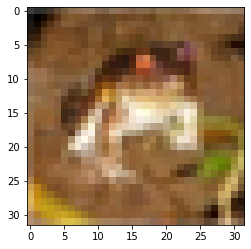

In [10]:
image, label = train_dataset[0]
plt.imshow(image.permute(1, 2, 0).numpy())
print (image.size())
print (classes[label])

## Модель и оптимайзер

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(9, 18, 3, padding=1)
        self.conv3 = nn.Conv2d(18, 36, 3, padding=1)
        self.fc1 = nn.Linear(576, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)
        self.dp1 = nn.Dropout()
        self.dp2 = nn.Dropout()

    def forward(self, x):
        # print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # print(x.shape)
        x = x.view(-1, 576)
        x = self.dp1(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dp2(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

net = Net().to(device)

In [12]:
optimizer = optim.Adam(net.parameters(), lr=3e-4)

## Трейн

In [13]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in tqdm(range(1, epochs+1)):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [14]:
train(net, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, test_data_loader, epochs=EPOCHS, device=device)

Epoch: 1, Training Loss: 2.20, Validation Loss: 2.04, accuracy = 0.22
Epoch: 2, Training Loss: 2.01, Validation Loss: 1.90, accuracy = 0.29
Epoch: 3, Training Loss: 1.87, Validation Loss: 1.74, accuracy = 0.35
Epoch: 4, Training Loss: 1.76, Validation Loss: 1.65, accuracy = 0.39
Epoch: 5, Training Loss: 1.69, Validation Loss: 1.58, accuracy = 0.41
Epoch: 6, Training Loss: 1.64, Validation Loss: 1.55, accuracy = 0.43
Epoch: 7, Training Loss: 1.60, Validation Loss: 1.51, accuracy = 0.44
Epoch: 8, Training Loss: 1.57, Validation Loss: 1.47, accuracy = 0.46
Epoch: 9, Training Loss: 1.54, Validation Loss: 1.44, accuracy = 0.47
Epoch: 10, Training Loss: 1.51, Validation Loss: 1.40, accuracy = 0.48
Epoch: 11, Training Loss: 1.49, Validation Loss: 1.38, accuracy = 0.49
Epoch: 12, Training Loss: 1.47, Validation Loss: 1.35, accuracy = 0.50
Epoch: 13, Training Loss: 1.45, Validation Loss: 1.34, accuracy = 0.51
Epoch: 14, Training Loss: 1.43, Validation Loss: 1.31, accuracy = 0.52
Epoch: 15, Trai